In [20]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [21]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [22]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

#import flask
from flask import Flask, jsonify

In [23]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [24]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [25]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [26]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [27]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [28]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [29]:
columns = inspector.get_columns('measurement')
for column in columns:
    print (column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [30]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date = list(np.ravel(recent_date))[0]
print(recent_date)

2017-08-23


In [31]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
session.query(func.count(Measurement.date)).all()
recent_date = dt.datetime.strptime(recent_date, '%Y-%m-%d')

recent_year = int(dt.datetime.strftime(recent_date, '%Y'))
recent_month = int(dt.datetime.strftime(recent_date, '%m'))
recent_day = int(dt.datetime.strftime(recent_date, '%d'))

one_year = dt.date(recent_year, recent_month, recent_day) - dt.timedelta(days=365)
one_year

datetime.date(2016, 8, 23)

In [32]:
# Perform a query to retrieve the data and precipitation scores
percp_data = (session.query(Measurement.date, Measurement.prcp).\
             filter(Measurement.date >= one_year).\
             order_by(Measurement.date).all())
percp_data.head()


[('2016-08-23', 0.0),
 ('2016-08-23', 0.15),
 ('2016-08-23', 0.05),
 ('2016-08-23', None),
 ('2016-08-23', 0.02),
 ('2016-08-23', 1.79),
 ('2016-08-23', 0.7),
 ('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.21),
 ('2016-08-25', 0.06),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.03),
 ('2016-08-26', 0.02),
 ('2016-08-26', 0.04),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.01),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.18),
 ('2016-08-27', 0.02),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.12),
 ('2016-08-27', None),
 ('2016-08-28', 0.01),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.6),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.17),
 ('2016-08-29', 0.04),
 ('2016-08-29', None),
 ('2016-08-29', 0.0),

In [33]:
# Save the query results as a Pandas DataFrame and set the index to the date column
percp_df = pd.DataFrame(percp_data)
percp_df = percp_df.set_index("date")

In [34]:
# Sort the dataframe by date
percp_df= percp_df.sort_index(ascending = True)
percp_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


<AxesSubplot:title={'center':'Percipitation Analysis'}, xlabel='date'>

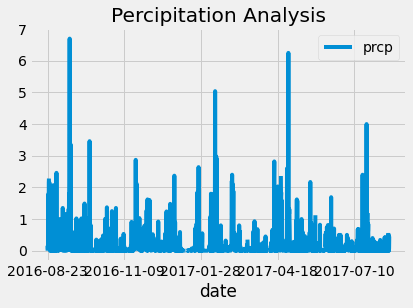

In [35]:
# Use Pandas Plotting with Matplotlib to plot the data
percp_df.plot(title = 'Percipitation Analysis')

In [36]:
# Use Pandas to calcualte the summary statistics for the precipitation data
percp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [37]:
# Design a query to calculate the total number stations in the dataset
stations_total = session.query(Station).count()
stations_total

9

In [38]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station,func.count(Measurement.station)).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [39]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_ID = most_active_stations[0][0]
most_active_station_ID
#highest temp
highest_temp = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == most_active_station_ID).all()
highest_temp
#lowest temp
lowest_temp = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == most_active_station_ID).all()
lowest_temp
#average temp
avg_temp = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station_ID).all()
avg_temp


print( f'The most active station ID is {most_active_station_ID}')
print( f'The highest temp is {highest_temp[0][0]}')
print( f'The lowest temp is {lowest_temp[0][0]}')
print( f'The average temp is {avg_temp[0][0]}')

The most active station ID is USC00519281
The highest temp is 85.0
The lowest temp is 54.0
The average temp is 71.66378066378067


<AxesSubplot:ylabel='Frequency'>

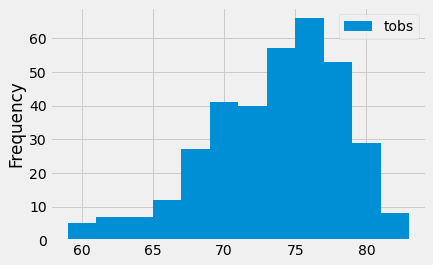

In [40]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_year = session.query(Measurement.date, Measurement.tobs).\
            filter(Measurement.date >= one_year).\
            filter(Measurement.station == most_active_station_ID).\
            order_by(Measurement.date).all()

temp_df = pd.DataFrame(temp_year)
temp_df = temp_df.set_index('date')
temp_df = temp_df.sort_index(ascending=True)
temp_df.head()

temp_df.plot(kind='hist', bins=12)

# Close session

In [41]:
# Close Session
session.close()